In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Building ARIMA Models
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Libraries for Evaluation
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
%matplotlib inline

In [3]:
# load dataset
df_AAPL = pd.read_csv('./datasets/AAPL_2yrs.csv', header=0, index_col=0)
df_AAPL.head()

,Open,High,Low,Close,Volume
Date,,,,,
6/8/2021,126.60,128.46,126.21,126.74,"74,403,774"
6/9/2021,127.21,127.75,126.52,127.13,"56,877,937"
6/10/2021,127.02,128.19,125.94,126.11,"71,186,421"
6/11/2021,126.53,127.44,126.10,127.35,"53,522,373"
6/14/2021,127.82,130.54,127.07,130.48,"96,906,490"


<class 'pandas.core.frame.DataFrame'>
Index: 505 entries, 6/8/2021 to 6/8/2023
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    505 non-null    float64
 1   High    505 non-null    float64
 2   Low     505 non-null    float64
 3   Close   505 non-null    float64
 4   Volume  505 non-null    object 
dtypes: float64(4), object(1)
memory usage: 23.7+ KB


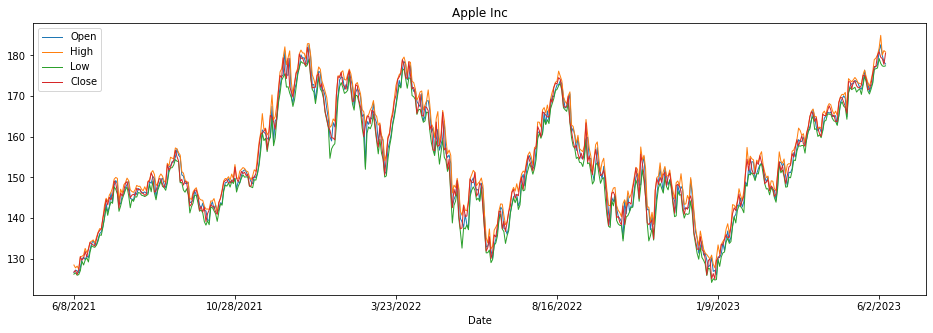

In [4]:
df_AAPL.info()
df_AAPL.plot(figsize=(16,5),lw=1, title="Apple Inc")
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

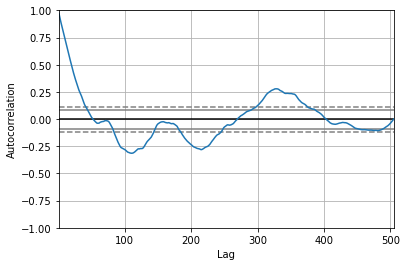

In [5]:
autocorrelation_plot(df_AAPL[["Open","High","Low","Close"]])

### Choosing Close Columns for model predictions

<class 'pandas.core.series.Series'>
Index: 505 entries, 6/8/2021 to 6/8/2023
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
505 non-null    float64
dtypes: float64(1)
memory usage: 7.9+ KB


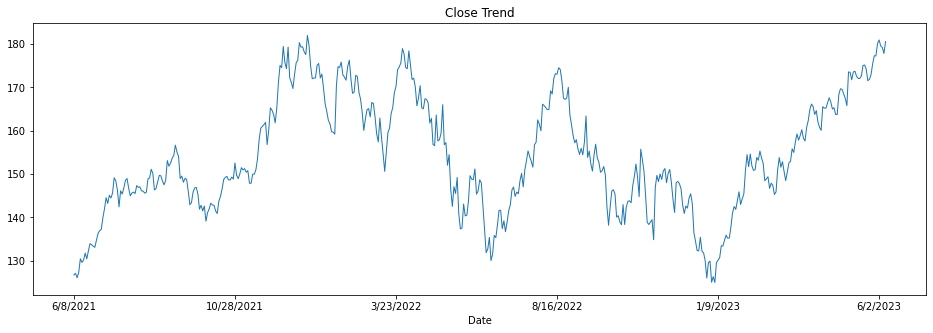

In [6]:
df_close = df_AAPL["Close"]
df_close.info()
df_close.plot(figsize=(16,5),lw=1, title="Close Trend")
plt.show()

### Split data for train and test

In [8]:
# Split the data for train and test
df_train = df_close[:485].copy()
df_test = df_close[485:].copy()

In [9]:
# Creating function to display ACF anf PACF plot
def plot_correlation(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
    # ACF
    plot_acf(df, ax=ax1, lags=30)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    
    # PACF
    plot_pacf(df, ax=ax2, lags=20)
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')

    # Lighten the borders
    ax1.spines['top'].set_alpha(.3); ax2.spines['top'].set_alpha(.3)
    ax1.spines['bottom'].set_alpha(.3); ax2.spines['bottom'].set_alpha(.3)
    ax1.spines['right'].set_alpha(.3); ax2.spines['right'].set_alpha(.3)
    ax1.spines['left'].set_alpha(.3); ax2.spines['left'].set_alpha(.3)

    ax1.tick_params(axis='both', labelsize=10)
    ax2.tick_params(axis='both', labelsize=10)
    plt.show()

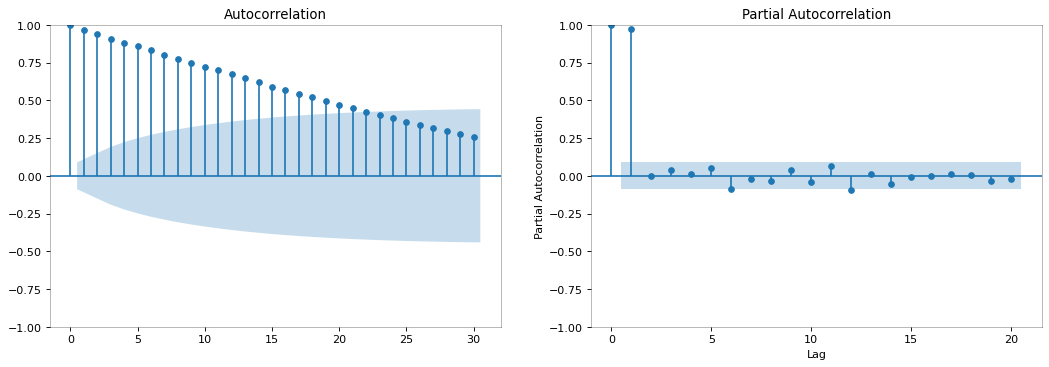

In [10]:
plot_correlation(df_train)

### Get p-value with ADF and KPSS test

In [11]:
#perform augmented Dickey-Fuller test to check if stationary
def ADF(df):
    result = adfuller(df)

    # Extract ADF Values
    print('Column Name: %s' % "Close Variable")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [12]:
ADF(df_train)

Column Name: Close Variable
ADF Statistic: -2.676704
p-value: 0.078157
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570


In [13]:
# KPSS Test 
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c")
    kpss_output = pd.Series(kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"])
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [14]:
kpss_test(df_train.values)

Results of KPSS Test:
Test Statistic            0.304446
p-value                   0.100000
Lags Used                12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## Transform to stationary

p.value: -1.019999999999996


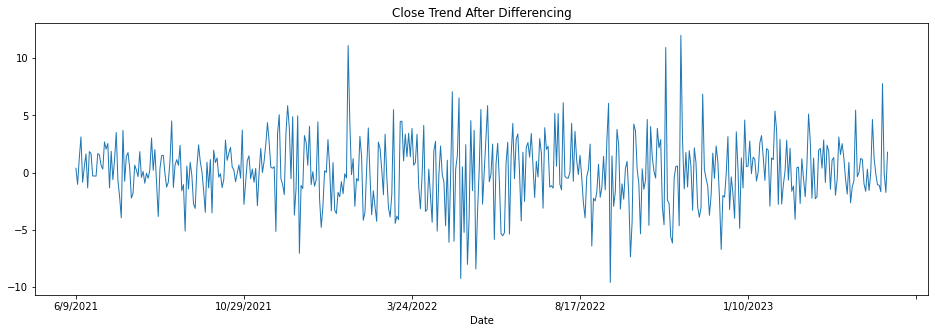

In [15]:
# Perform differencing
df_train_diff = df_train.diff().dropna()
df_train_diff.plot(figsize=(16,5), lw=1, title="Close Trend After Differencing")
print(f"p.value: {df_train_diff[1]}" )
plt.show()

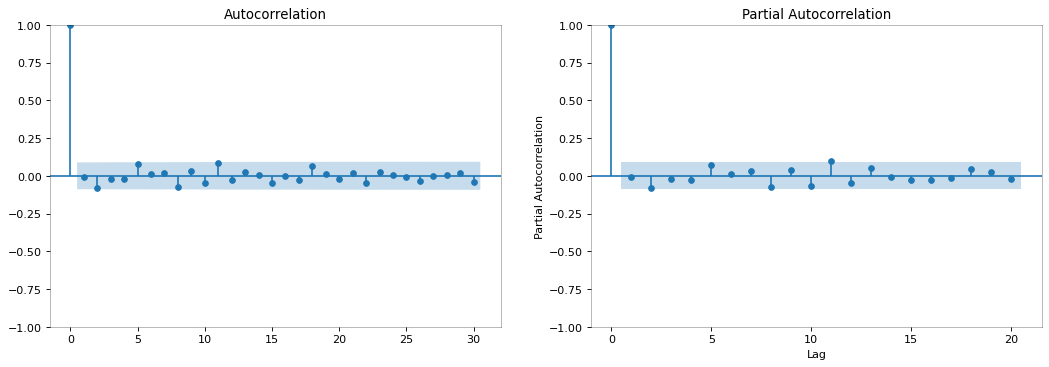

In [16]:
plot_correlation(df_train_diff)

## Determine model parameters p, q

In [17]:
# library that determine best parameters for ARIMA model
import pmdarima as pm
from pmdarima import auto_arima

In [19]:
model = auto_arima(df_train, start_p=0, start_q=0,
                          max_p=2, max_q=2,m=9,start_P=0,start_Q=0, 
                          max_P = 2, max_Q = 2,
                          seasonal=True,
                          d=1,D=1,trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[9]             : AIC=2675.597, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[9]             : AIC=2535.947, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[9]             : AIC=inf, Time=1.16 sec
 ARIMA(1,1,0)(0,1,0)[9]             : AIC=2676.064, Time=0.15 sec
 ARIMA(1,1,0)(2,1,0)[9]             : AIC=2497.526, Time=0.41 sec
 ARIMA(1,1,0)(2,1,1)[9]             : AIC=inf, Time=3.08 sec
 ARIMA(1,1,0)(1,1,1)[9]             : AIC=inf, Time=1.55 sec
 ARIMA(0,1,0)(2,1,0)[9]             : AIC=2495.589, Time=0.31 sec
 ARIMA(0,1,0)(1,1,0)[9]             : AIC=2534.119, Time=0.19 sec
 ARIMA(0,1,0)(2,1,1)[9]             : AIC=inf, Time=1.87 sec
 ARIMA(0,1,0)(1,1,1)[9]             : AIC=inf, Time=1.15 sec
 ARIMA(0,1,1)(2,1,0)[9]             : AIC=2497.512, Time=0.39 sec
 ARIMA(1,1,1)(2,1,0)[9]             : AIC=2489.805, Time=1.02 sec
 ARIMA(1,1,1)(1,1,0)[9]             : AIC=2527.864, Time=0.77 sec
 ARIMA(1,1,1)(2,1,1)[9]             : AIC=inf, Time=2.41 s

## Fit the ARIMA Model

In [18]:
model = ARIMA(df_train, order=(0,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  485
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1201.282
Date:                Fri, 16 Jun 2023   AIC                           2404.564
Time:                        12:13:46   BIC                           2408.746
Sample:                             0   HQIC                          2406.207
                                - 485                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         8.3821      0.422     19.882      0.000       7.556       9.208
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                32.47
Prob(Q):                              0.84   Pr

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## Make time series prediction

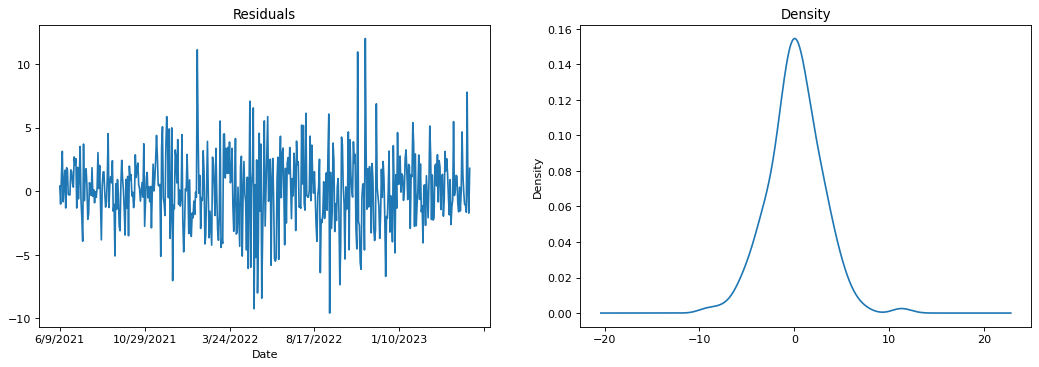

In [19]:
# Getting residuals pattern
# To make sure model capture adequate information from the data
residuals = model_fit.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(16,5), dpi=80)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

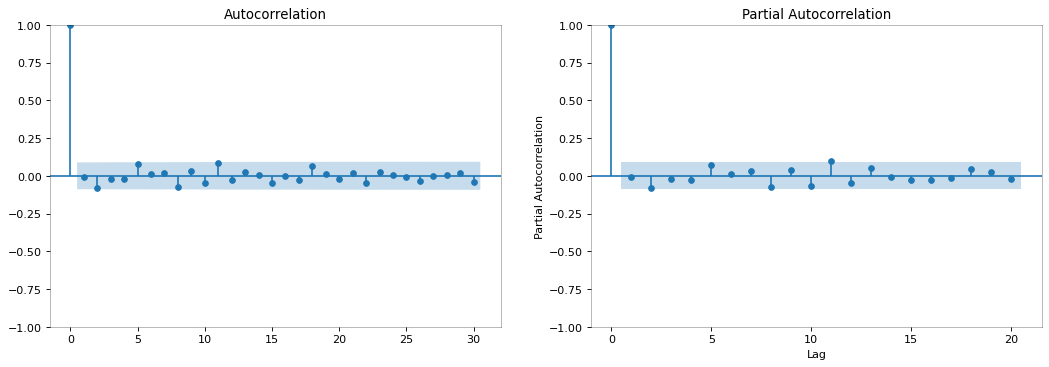

In [20]:
plot_correlation(residuals)

In [21]:
forecast = model_fit.forecast(len(df_test))

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [22]:
forecast.index = df_test.index
new_df = pd.concat([forecast, df_test], axis=1)
new_df

,predicted_mean,Close
Date,,
5/11/2023,173.56,173.75
5/12/2023,173.56,172.57
5/15/2023,173.56,172.07
5/16/2023,173.56,172.07
5/17/2023,173.56,172.69
5/18/2023,173.56,175.05
5/19/2023,173.56,175.16
5/22/2023,173.56,174.20
5/23/2023,173.56,171.56


<AxesSubplot:xlabel='Date'>

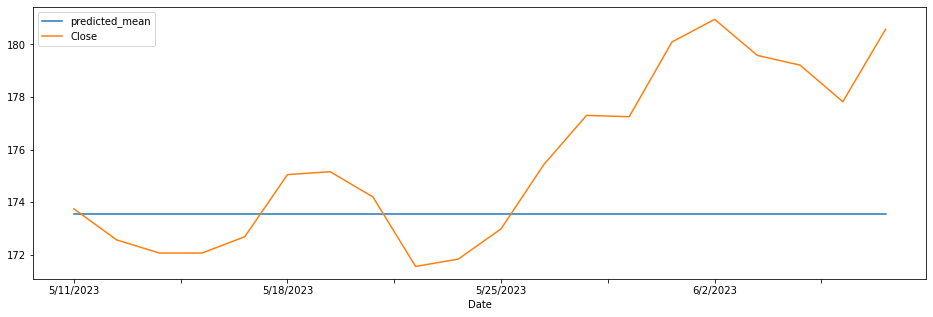

In [23]:
new_df.plot(figsize=(16,5))

## Fit the SARIMAX Model

In [27]:
train = df_close[:485].copy()
test = df_close[485:].copy()

In [28]:
final_model = SARIMAX(train,order=(0,1,1),seasonal_order=(2,1,0,12)) # Best model:  ARIMA(0,1,1)(2,1,0)[12] 
result = final_model.fit()
print(result.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.60555D+00    |proj g|=  8.27923D-02

At iterate    5    f=  2.56427D+00    |proj g|=  2.66528D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     11      1     0     0   8.475D-06   2.564D+00
  F =   2.5642709131835666     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                      SARIMAX Results                                      
Dep. Variable:                          

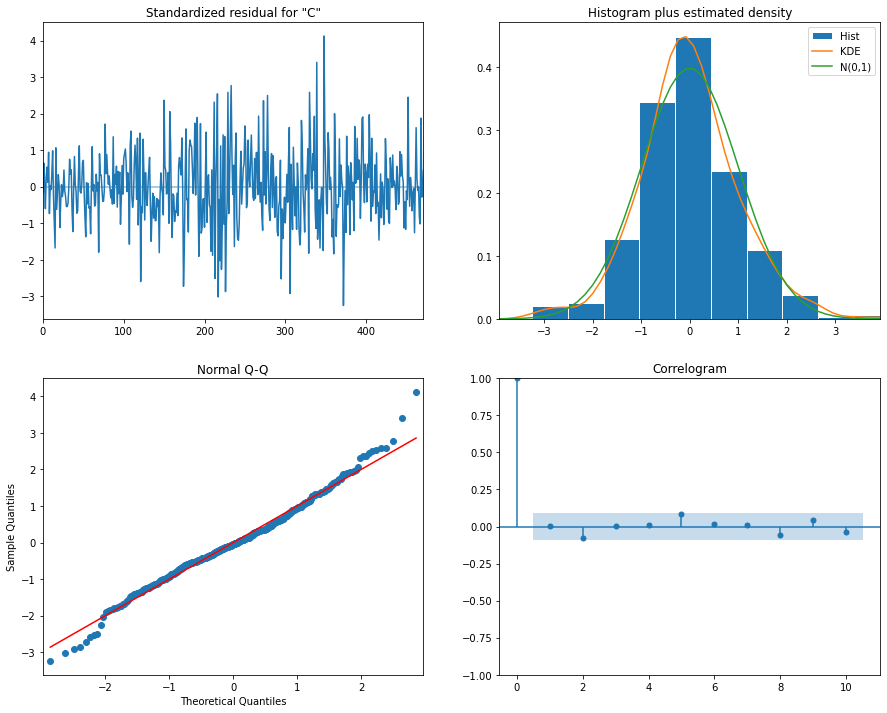

In [29]:
result.plot_diagnostics(figsize=(15, 12));

In [30]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
# Best model:  ARIMA(0,1,0)(2,1,0)[12]   
predictions = result.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,0)(2,1,0,12) Predictions')# Plot predictions against known values

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [31]:
predictions.index = test.index
joined_df = pd.concat([predictions, test], axis=1)
joined_df

,"SARIMA(0,1,0)(2,1,0,12) Predictions",Close
Date,,
5/11/2023,173.960952,173.75
5/12/2023,172.556362,172.57
5/15/2023,173.969683,172.07
5/16/2023,174.571350,172.07
5/17/2023,175.780379,172.69
5/18/2023,175.114819,175.05
5/19/2023,175.824172,175.16
5/22/2023,176.263767,174.20
5/23/2023,179.982391,171.56


9 Seasonal differencing


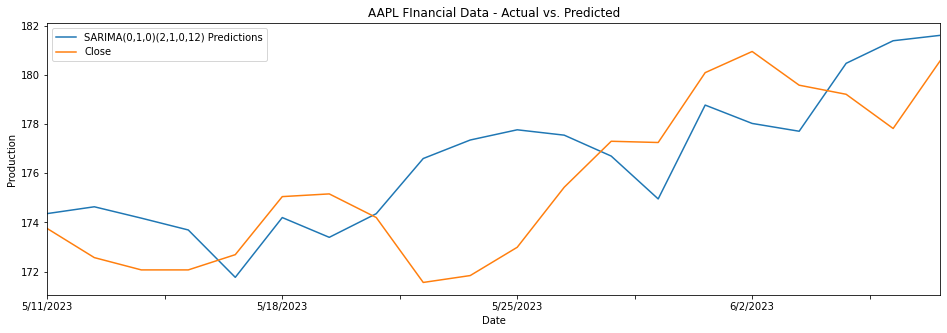

In [26]:
title = 'AAPL FInancial Data - Actual vs. Predicted'
ylabel='Production'
xlabel='Date'
ax = joined_df.plot(legend=True, figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
print("9 Seasonal differencing")

12 Seasonal differencing


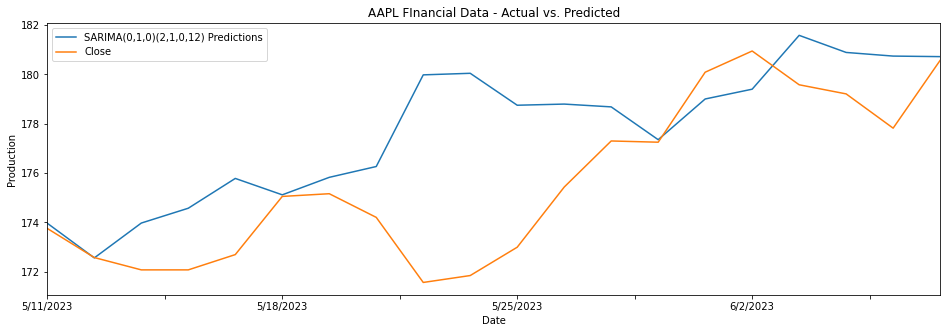

In [32]:
title = 'AAPL FInancial Data - Actual vs. Predicted'
ylabel='Production'
xlabel='Date'
ax = joined_df.plot(legend=True, figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
print("12 Seasonal differencing")